In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import yfinance as yf
import pandas as pd
from scripts.utils import load_config
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Let's set up our config settings so we have what we need.
config_path = os.path.join(project_root, 'config', 'config.yaml')
config = load_config(config_path)


In [4]:
# Now let's bring in the data we need from our config file.
core_tickers = config['yfinance']['core_tickers']
start_date = config['yfinance']['start_date']
end_date = config['yfinance']['end_date']

#### Before we download our data and create our dataframe for our core stocks, we will need to calculate the technical indicators we will use for this dataset.  These indicators will be mostly calculated from base features such as our Close and Volume, though there are many more we can use.

In [5]:
# Note our secondary stock data will also have these indicators as well, so we have to implement naming conventions so that when we eventually merge the datasets there's no conflicts.

def calculate_indicators(df, window_sma = 50, window_ema = 50, window_rsi = 14):
    # Simple Moving Average (SMA)
    df['SMA_core'] = df['Close_core'].rolling(window=window_sma).mean()
    
    # Exponential Moving Average (EMA)
    df['EMA_core'] = df['Close_core'].ewm(span=window_ema, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df['Close_core'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window_rsi).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI_core'] = 100 - (100 / (1 + rs))

    
    # Bollinger Bands, the calculation will automatically create the 3 feature columns for us.
    df['BBM_core'] = df['Close_core'].rolling(window=window_sma).mean()
    df['BBU_core'] = df['BBM_core'] + 2 * df['Close_core'].rolling(window=window_sma).std()
    df['BBL_core'] = df['BBM_core'] - 2 * df['Close_core'].rolling(window=window_sma).std()

    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = df['Close_core'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close_core'].ewm(span=26, adjust=False).mean()
    df['MACD_core'] = ema_12 - ema_26
    df['MACD_Signal_core'] = df['MACD_core'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist_core'] = df['MACD_core'] - df['MACD_Signal_core']
    
    # Average Directional Index (ADX)
    high_low = df['High_core'] - df['Low_core']
    high_close = abs(df['High_core'] - df['Close_core'].shift(1))
    low_close = abs(df['Low_core'] - df['Close_core'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    plus_dm = df['High_core'].diff(1).where(lambda x: x > 0, 0)
    minus_dm = df['Low_core'].diff(1).where(lambda x: x < 0, 0).abs()

    tr_14 = true_range.rolling(window=14).sum()
    plus_dm_14 = plus_dm.rolling(window=14).sum()
    minus_dm_14 = minus_dm.rolling(window=14).sum()

    plus_di = 100 * (plus_dm_14 / tr_14)
    minus_di = 100 * (minus_dm_14 / tr_14)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    df['ADX_14_core'] = dx.rolling(window=14).mean()

    
    # Commodity Channel Index (CCI)
    typical_price = (df['High_core'] + df['Low_core'] + df['Close_core']) / 3
    mean_typical_price = typical_price.rolling(window=20).mean()
    mean_deviation = (typical_price - mean_typical_price).abs().rolling(window=20).mean()
    df['CCI_20_core'] = (typical_price - mean_typical_price) / (0.015 * mean_deviation)

    
    # Average True Range (ATR)
    high_low = df['High_core'] - df['Low_core']
    high_close = abs(df['High_core'] - df['Close_core'].shift(1))
    low_close = abs(df['Low_core'] - df['Close_core'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14_core'] = true_range.rolling(window=14).mean()

    
    # Stochastic Oscillator (Stoch)
    lowest_low = df['Low_core'].rolling(window=14).min()
    highest_high = df['High_core'].rolling(window=14).max()
    df['Stoch_K_core'] = 100 * ((df['Close_core'] - lowest_low) / (highest_high - lowest_low))
    df['Stoch_D_core'] = df['Stoch_K_core'].rolling(window=3).mean()

    
    # Momentum indicators using different periods
    df['Momentum_1_core'] = df['Close_core'] - df['Close_core'].shift(1)
    df['Momentum_3_core'] = df['Close_core'] - df['Close_core'].shift(3)
    df['Momentum_7_core'] = df['Close_core'] - df['Close_core'].shift(7)
    df['Momentum_30_core'] = df['Close_core'] - df['Close_core'].shift(30)
    df['Momentum_50_core'] = df['Close_core'] - df['Close_core'].shift(50)

    
    # On-Balance Volume (OBV)
    df['OBV_core'] = (df['Volume_core'] * ((df['Close_core'] > df['Close_core'].shift(1)).astype(int) - (df['Close_core'] < df['Close_core'].shift(1)).astype(int))).cumsum()
    
    
    
    return df

In [5]:



# Now let's start to bring in the data we need with the variables we just created.
def core_tickers_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        print(f"Processing {ticker}. . .")
        try:
            stock_data = yf.download(ticker, start = start, end = end)[["Close", "Volume", "Open", "High", "Low"]]
            
            if stock_data.empty:
                print(f"No data available for {ticker}.")
                continue
            
            stock_data = calculate_indicators(stock_data)
            
            stock_data.rename(columns = {
                'Close' : 'Close_core',
                'Open' : 'Open_core',
                'High' : 'High_core',
                'Low' : 'Low_core',
                'Volume' : 'Volume_core',
                }, inplace = True)
            
            data[ticker] = stock_data
            print(f"Successfully processed {ticker}.")
            
        except Exception as e:
            print(f" Error downloading data for {ticker}: {e}")
            
    if not data:
        print("No data downloaded for any ticker.")
    return data

def prep_time_series_df(data):
    df_list = []
    for ticker, df in data.items():
        print(f"Preparing data for {ticker}. . .")
        df['Ticker'] = ticker
        df_list.append(df)
    
    if df_list:
        combined_df = pd.concat(df_list)
        combined_df.reset_index(inplace=True)
        print("Columns after concatenation:", combined_df.columns)
        return combined_df
    else:
        print("No data to concatenate.")
        raise ValueError("No objects to concatenate.")
    
def check_missing_vals(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data

core_data = core_tickers_data(core_tickers, start_date, end_date)

if not core_data:
    print("No data downloaded.  Exiting script.")
    exit()

df = prep_time_series_df(core_data)

if 'Close_sec' in df.columns:
    print("Warning: 'Close_sec column detected.  Investigating. . .")
else:
    print("Close_sec column not detected.  Proceeding.")

# Check the new dataframe real quick
print(f"Dataframe shape: {df.shape}")

# Set the start date to 03-14-2019 for our data pull so we have a fresh clean rolling window.
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] >= '2019-03-14']

df_missing = check_missing_vals(df)
print("Missing values before filling methods:", df_missing)

# We have some missing values we need to address here.  Let's take a look.
df.head(15)


Processing AAPL. . .


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 Error downloading data for AAPL: 'Close_core'
Processing MSFT. . .
 Error downloading data for MSFT: 'Close_core'
Processing GOOG. . .


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 Error downloading data for GOOG: 'Close_core'
Processing AMZN. . .
 Error downloading data for AMZN: 'Close_core'
Processing NVDA. . .


[*********************100%%**********************]  1 of 1 completed


 Error downloading data for NVDA: 'Close_core'
Processing META. . .


[*********************100%%**********************]  1 of 1 completed


 Error downloading data for META: 'Close_core'
Processing TSLA. . .


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 Error downloading data for TSLA: 'Close_core'
Processing PFE. . .
 Error downloading data for PFE: 'Close_core'
Processing MA. . .


[*********************100%%**********************]  1 of 1 completed


 Error downloading data for MA: 'Close_core'
Processing PG. . .


[*********************100%%**********************]  1 of 1 completed


 Error downloading data for PG: 'Close_core'
No data downloaded for any ticker.
No data downloaded.  Exiting script.
No data to concatenate.


ValueError: No objects to concatenate.

: 

In [ ]:
# Let's start to examine our missing values more closely.  Looks like we can easily impute the RSI data, that's not an issue.  The SMA on the other hand needs a closer look.
print(df_missing)

Momentum_50_core    10
dtype: int64


In [6]:
# Let's look at the location of those missing values and see if we can see if/how they are grouped.
plt.figure(figsize = (12,7))
sns.heatmap(df.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x700 with 0 Axes>

#### Looking at the above you can't really tell where the missing values are, since we only have 10 missing values!.  These we will impute with surrounding values.  We will look to impute here with a combination of forward filling, back filling, and then linear interpolating as well to get the best idea of what those missing values are so we don't have to drop them entirely.

In [ ]:
# Let's make a quick function for our imputation and interpolation, we may need this again.
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

df = df.copy()

for col in df.columns:
    if df[col].isnull().any():
        df.loc[:, col] = fill_missing_vals(df[[col]])[col]



print(df.isna().sum())


print(df.isna().sum())

Date                0
Close_core          0
Volume_core         0
Open_core           0
High_core           0
Low_core            0
SMA_core            0
EMA_core            0
RSI_core            0
BBM_core            0
BBU_core            0
BBL_core            0
MACD_core           0
MACD_Signal_core    0
MACD_Hist_core      0
ADX_14_core         0
CCI_20_core         0
ATR_14_core         0
Stoch_K_core        0
Stoch_D_core        0
Momentum_1_core     0
Momentum_3_core     0
Momentum_7_core     0
Momentum_30_core    0
Momentum_50_core    0
OBV_core            0
Ticker              0
dtype: int64
Date                0
Close_core          0
Volume_core         0
Open_core           0
High_core           0
Low_core            0
SMA_core            0
EMA_core            0
RSI_core            0
BBM_core            0
BBU_core            0
BBL_core            0
MACD_core           0
MACD_Signal_core    0
MACD_Hist_core      0
ADX_14_core         0
CCI_20_core         0
ATR_14_core        

C:\Users\ryanm\AppData\Local\Temp\ipykernel_40736\3017235574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_40736\3017235574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_40736\3017235574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method = 'linear', inplace = True)


In [6]:
# So far so good.  Now let's start to set up and read in our exogenous data.
def dl_exogenous_data(start, end, exo_tickers, stock_start_date):
    exo_data = {}
    for name, ticker in exo_tickers.items():
        try:
            data = yf.download(ticker, start = start, end = end)
            exo_data[name] = data['Close']
        except Exception as e:
            print(f"Error downloading data for {name} ({ticker}): {e}")
    exo_df = pd.DataFrame(exo_data)
    exo_df.reset_index(inplace=True)
    
    # Let's make sure our Date column is converted to datetime format to be used when we merge our dataframes for time series.
    exo_df['Date'] = pd.to_datetime(exo_df['Date'])
    
    exo_df_filtered = exo_df[exo_df['Date'] >= pd.to_datetime(stock_start_date)]
    
    return exo_df_filtered

stock_start_date = '2019-03-14'
exo_tickers = config['yfinance']['exogenous_tickers']
exo_df = dl_exogenous_data(start_date, end_date, exo_tickers, stock_start_date)




# Let's take a quick look at the output.
print(exo_df.shape)
print(exo_df.describe())
exo_df.head(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(1415, 19)
                      Date  interest_rates_10yr         gold       copper  \
count                 1415          1365.000000  1366.000000  1366.000000   
mean   2021-11-28 04:48:00             2.485522  1814.614273     3.630447   
min    2019-03-14 00:00:00             0.499000  1269.300049     2.119500   
25%    2020-07-21 12:00:00             1.479000  1711.749969     2.909250   
50%    2021-11-29 00:00:00             2.068000  1818.549988     3.757500   
75%    2023-04-06 12:00:00             3.785000  1938.149963     4.239500   
max    2024-08-14 00:00:00             4.988000  2466.699951     5.119000   
std                    NaN             1.302289   242.180751     0.710585   

          platinum       silver    crude_oil  natural_gas         corn  \
count  1365.000000  1365.000000  1366.000000  1366.000000  1365.000000   
mean    958.765640    22.231136    69.041274     3.387759   512.124176   
min     595.900024    11.735000   -37.630001     1.482000   302.750000   

,Date,interest_rates_10yr,gold,copper,platinum,silver,crude_oil,natural_gas,corn,wheat,volatility_index,exchange_rate_usd_eur,exchange_rate_usd_jpy,sp500,nasdaq_100,dow_jones_industrial_average,consumer_confidence_index,vanguard_total_world_stock_etf,us_treasury_bond_etf
52,2019-03-14,2.630,1293.400024,2.8885,825.599976,15.101,58.610001,2.855,361.50,448.25,13.50,1.133106,111.195999,2808.479980,7243.009766,25709.939453,124.010002,73.000000,24.870001
53,2019-03-15,2.593,1301.800049,2.9035,830.299988,15.253,58.520000,2.795,373.25,462.25,12.88,1.130838,111.752998,2822.479980,7306.990234,25848.869141,125.029999,73.570000,24.920000
54,2019-03-18,2.602,1300.300049,2.9035,832.599976,15.251,59.090000,2.850,371.50,456.75,13.10,1.131977,111.560997,2832.939941,7326.279785,25914.099609,124.660004,73.900002,24.910000
55,2019-03-19,2.614,1305.000000,2.9195,851.200012,15.301,59.029999,2.874,371.25,456.50,13.56,1.133620,111.373001,2832.570068,7349.279785,25887.380859,124.570000,73.910004,24.900000
56,2019-03-20,2.535,1300.500000,2.9155,858.200012,15.245,59.830002,2.820,371.50,464.75,13.91,1.135486,111.401001,2824.229980,7380.750000,25745.669922,125.760002,73.790001,25.010000
57,2019-03-21,2.537,1306.099976,2.9000,859.700012,15.372,59.980000,2.821,376.25,466.50,13.63,1.142792,110.660004,2854.879883,7493.270020,25962.509766,126.400002,74.230003,25.010000
58,2019-03-22,2.455,1311.599976,2.8360,847.200012,15.345,59.040001,2.753,378.25,466.00,16.48,1.137501,110.806000,2800.709961,7326.060059,25502.320312,125.500000,72.720001,25.150000
59,2019-03-25,2.420,1321.900024,2.8495,856.500000,15.507,58.820000,2.755,379.75,469.50,16.33,1.129586,110.081001,2798.360107,7316.959961,25516.830078,125.279999,72.419998,25.190001
60,2019-03-26,2.414,1314.300049,2.8505,858.900024,15.371,59.939999,2.740,377.25,469.25,14.68,1.131580,110.068001,2818.459961,7351.149902,25657.730469,125.540001,72.849998,25.190001
61,2019-03-27,2.374,1309.900024,2.8580,855.599976,15.239,59.410000,2.713,373.75,469.50,15.15,1.127485,110.554001,2805.370117,7308.189941,25625.589844,126.379997,72.580002,25.250000


In [10]:
def check_missing_vals(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data

# Just looking at the sample readout we can see we have at least one row of missing values, time to investigate!
exo_df_missing = check_missing_vals(exo_df)
print(exo_df_missing.isna().sum())



def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

# First, check for missing values
missing_data = check_missing_vals(exo_df)
print("Missing values before filling:")
print(missing_data)

# If there are missing values, fill them
if not missing_data.empty:
    print("Filling missing values...")
    exo_df = fill_missing_vals(exo_df)
    print("Missing values have been filled.")

# Check for missing values after filling
print("Checking missing values after filling:")
missing_data_after = check_missing_vals(exo_df)
print(missing_data_after)




0
Missing values before filling:
interest_rates_10yr               50
gold                              49
copper                            49
platinum                          50
silver                            50
crude_oil                         49
natural_gas                       49
corn                              50
wheat                             50
volatility_index                  50
exchange_rate_usd_eur              1
exchange_rate_usd_jpy              1
sp500                             50
nasdaq_100                        50
dow_jones_industrial_average      50
consumer_confidence_index         50
vanguard_total_world_stock_etf    50
us_treasury_bond_etf              50
dtype: int64
Filling missing values...
Missing values have been filled.
Checking missing values after filling:
Series([], dtype: int64)


#### With just a couple quick functions we have reviewed and imputed our missing values.  Now that they are filled let's take a quick look to see how our exogenous data correlates with each other.

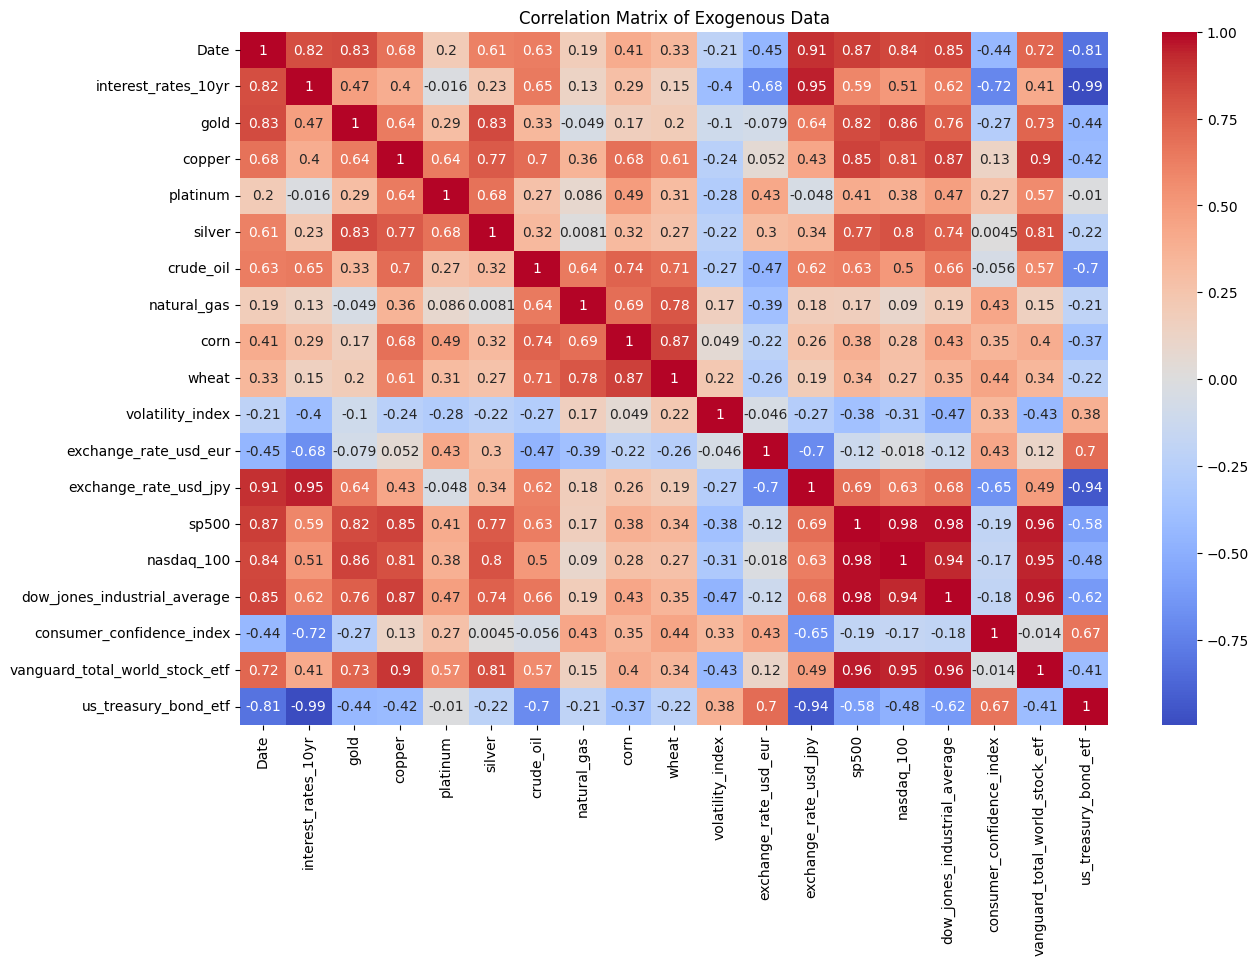

In [14]:
# Now let's plot the correlation matrix to see the relationship between missing values and their corresponding features.
plt.figure(figsize = (14,9))
sns.heatmap(exo_df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Exogenous Data')
plt.show()

#### What we can take from the above plot is that the market indexes are all highly correlated, meaning when one of those features has a missing value there is a high likelihood (over 90%) that another commodity will also be missing data for that date.  We can also see that there is a pretty strong correlation with copper and silver (though not as much) with our indexes and specfically the vanguard total world stock.  Though conversely the group of natural gas, corn, and wheat have a pretty low correlation with these features.  

#### Before saving and moving on let's reset the index and check the .head() statement to make sure everything looks fine.

In [16]:
# Before saving I want to take both of these dataframes and make sure Date is our index for our EDA phase.
#df.reset_index(drop = True, inplace = True)
#df.set_index('Date', inplace = True)

exo_df.reset_index(drop = True, inplace = True)
exo_df.set_index('Date', inplace = True)

#print(df.head())
print(exo_df.head())

            interest_rates_10yr         gold  copper    platinum  silver  \
Date                                                                       
2019-03-14                2.630  1293.400024  2.8885  825.599976  15.101   
2019-03-15                2.593  1301.800049  2.9035  830.299988  15.253   
2019-03-18                2.602  1300.300049  2.9035  832.599976  15.251   
2019-03-19                2.614  1305.000000  2.9195  851.200012  15.301   
2019-03-20                2.535  1300.500000  2.9155  858.200012  15.245   

            crude_oil  natural_gas    corn   wheat  volatility_index  \
Date                                                                   
2019-03-14  58.610001        2.855  361.50  448.25             13.50   
2019-03-15  58.520000        2.795  373.25  462.25             12.88   
2019-03-18  59.090000        2.850  371.50  456.75             13.10   
2019-03-19  59.029999        2.874  371.25  456.50             13.56   
2019-03-20  59.830002        2.820 

In [17]:
# Great, let's save this data to another csv file for quick reference if we should need it.
#df.to_csv(os.path.join(project_root, 'data', 'core_stock_data.csv'), index = True)

exo_df.to_csv(os.path.join(project_root, 'data', 'exogenous_data.csv'), index = True)

